In [39]:
import numpy as np
import h5py as h5
import sys
import physical_data as const
from read_parameter_file import read_params
import reading_data_for_los as RD
import matplotlib.pyplot as plt
from computeibb import computeibb as computeib
from prodata import projectdata
import time
from intergrid import Intergrid      

In [2]:
#Load dummy parameters from a "typical" specwizard run 
parameters = read_params('dummy.par')

#Load a small EAGLE box for testing
fname = "/home/andres/small_snap/snap_028_z000p000"

#Load a example of a postprocess LOS file
fname2 = "/home/andres/part_los_z0.010"

#Load class that contianes the particle information i,e position, velocities etc.
loss = RD.read_particle_data_from_los(fname2,1)        

#Load the class the contains the header information
simdata = RD.read_header(fname2)

#Conversion factors 
convert = RD.units_and_factors_for_los(fname2)

# This outputs which is what is the long axis from the LOS  (0=x,1=y,z=2)
los_long_axis = np.argmax([(loss.Position[:,0].max()-loss.Position[:,0].min()) /simdata.HubbleParam * simdata.ExpansionFactor,(loss.Position[:,1].max()-loss.Position[:,1].min()) /simdata.HubbleParam * simdata.ExpansionFactor,(loss.Position[:,2].max()-loss.Position[:,2].min()) /simdata.HubbleParam * simdata.ExpansionFactor])

LOS1/PartType0/Positions


In [3]:
acurrent = simdata.ExpansionFactor
zcurrent = simdata.Redshift
CurrentHubbleCt = 100. * simdata.HubbleParam *  np.sqrt(1. + simdata.Omega0*(1./acurrent-1.) + simdata.OmegaLambda* (acurrent**2-1.)) /acurrent
boxkms = simdata.BoxSize / simdata.HubbleParam * acurrent * CurrentHubbleCt

vpixsizekms = 1
nveloc = int(boxkms / vpixsizekms) + 1

In [4]:
Coordinates_conv     = convert.Pos_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Pos_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Pos_cgs_unit) - np.log10(convert.cm_per_mpc) # in physical Mpc
Coordinates_conv     = 10.0**Coordinates_conv
Position = loss.Position * Coordinates_conv
BoxPhys = simdata.BoxSize * Coordinates_conv
ParticleSmoothingLength = loss.ParticleSmoothingLength * Coordinates_conv

In [5]:
Velocity_conv = convert.Vel_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Vel_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Vel_cgs_unit) - np.log10(1e5) #$ physical km/s
Velocity_conv = 10.0**Velocity_conv
Velocity = loss.Velocity * Velocity_conv

In [6]:
Density_conv = convert.Dens_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Dens_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Dens_cgs_unit)- np.log10(convert.proton_mass)
Density_conv = 10**Density_conv
ParticleDensity = loss.ParticleDensity * Density_conv
#Convert from total density to *Hydrogen* number density
ParticleDensity = ParticleDensity * loss.MassFractions[:,0]
Metallicity = loss.Metallicity[...] / const.Zmass_solar  #metallicity in solar units


In [7]:
Mass_conv = convert.Mass_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Mass_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Mass_cgs_unit) - np.log10(convert.solar_mass)
Mass_conv = 10.0**Mass_conv
Mass   = loss.Mass * Mass_conv

In [8]:
Temp_Conv           = convert.Temp_aexp_exp * np.log10(simdata.ExpansionFactor) + convert.Temp_h_exp * np.log10(simdata.HubbleParam) + np.log10(convert.Temp_cgs_unit) #! cgs
Temp_Conv           = 10.0**Temp_Conv
ParticleTemperature = loss.ParticleTemperature * Temp_Conv 

In [9]:
los_long_axis

1

In [10]:
Position_2 = np.zeros(np.shape(Position),dtype=np.float128)

if los_long_axis == 0:
    Position_2[:,0] = Position[:,1]
    Position_2[:,1] = Position[:,2]
    Position_2[:,2] = Position[:,0]
elif los_long_axis == 1:
    Position_2[:,0] = Position[:,2]
    Position_2[:,1] = Position[:,0]
    Position_2[:,2] = Position[:,1]
    
else:
    Position_2[:,0] = Position[:,0]
    Position_2[:,1] = Position[:,1]
    Position_2[:,2] = Position[:,2]


In [12]:
print(x_physical,y_physical)

67.31771097317782 22.452915650062227


In [13]:

ions_to_do = [parameters.doH1,parameters.doHe2,parameters.doC2,
parameters.doC3,parameters.doC4,parameters.doN2,parameters.doN3,parameters.doN4,
parameters.doN5,parameters.doO1,parameters.doO3,parameters.doO4,parameters.doO5,
parameters.doO6,parameters.doO7,parameters.doMg2,parameters.doNe8,parameters.doAl2,
parameters.doAl3,parameters.doSi2,parameters.doSi3,parameters.doSi4,parameters.doS5,
parameters.doFe2,parameters.doFe3,parameters.do21cm]

number_ions = np.sum(ions_to_do) # was nion in the original F90 subroutine, prob superflues in this implimentation

number_species =  number_ions# was nspecies in the original F90

if (number_ions==0):
    print("ERROR: No ions were selected!")
    sys.exit()
if (parameters.doH1 and parameters.do_long_spectrum and parameters.nlyman > const.nlyman_all):
    print('ERROR: nlyman > n_lines_max')
    sys.exit()
if (const.Lambda_H1[0] !=  const.lyalpha):    # a bit superflus
    print( 'ERROR: Lambda_H1[0] and lyalpha  are not equal ')

ionbal_names = np.array(["h1","he2","c2","c3","c4","n2","n3","n4","n5","o1","o3","o4","o5","o6",  #The elements of this list must be in the same order as
                "o7","mg2","ne8","al2","al3","si2","si3","si4","s5","fe2","fe3","21cm"])          # ions_to_do



In [14]:
ionbal_to_use = ionbal_names[ions_to_do]

In [15]:
ionbal_to_use

array(['h1', 'n2', 'n5', 'ne8', 'si2'], dtype='<U4')

In [16]:
# something like this...
ionss = []
first_iteration = True

for ion_file in ionbal_to_use:
    with h5.File(parameters.ibdir+ion_file+".hdf5","r") as f:
        if first_iteration:
            z_ranges_table = f["/redshift"][...]
            logt_table = f["/logt"][...]
            logd_table = f["/logd"][...]
            first_iteration = False

        ionss.append(f["/ionbal"][...].flatten())
        print(ion_file+' Ionization table loaded')


h1 Ionization table loaded
n2 Ionization table loaded
n5 Ionization table loaded
ne8 Ionization table loaded
si2 Ionization table loaded


In [19]:
ElementAtomicMass = [const.atom_dic[item][0] for item in ionbal_to_use]
MassFraction_indx = [const.atom_dic[item][-1] for item in ionbal_to_use]

In [21]:
loss.MassFractions[500,MassFraction_indx] * loss.Mass[500] / ElementAtomicMass[:]

array([5.50501816e+19, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [22]:
ParticleNeutralHFraction = loss.ParticleNeutralHFraction
ParticleMolecularHFraction = loss.ParticleMolecularHFraction

In [23]:
NGas = len(Mass)
ib_logt = logt_table
ib_logd = logd_table
ib_redshift =z_ranges_table
ionizbal = np.log10(ionss)
ion_elnr = MassFraction_indx 
nion = len(ionbal_to_use)
nz = len(z_ranges_table)
nznt = nz*len(ib_logt)

<ipython-input-23-61848e83ba78>:5: RuntimeWarning: divide by zero encountered in log10
  ionizbal = np.log10(ionss)


In [24]:
n_ion     =  np.zeros((nion,nveloc))
veloc_ion =  np.zeros((nion,nveloc))
temp_ion  =  np.zeros((nion,nveloc))
rho_ion   =  np.zeros((nion,nveloc))
rho_tot   =  np.zeros(nveloc)
temp_tot   =  np.zeros(nveloc)
met_tot   =  np.zeros(nveloc)
veloc_tot   =  np.zeros(nveloc)

In [25]:
nveloc

6742

In [26]:
#blah = projectdata(Position, Velocity, ParticleSmoothingLength, ParticleDensity, ParticleTemperature, ParticleNeutralHFraction, ParticleMolecularHFraction,
#Metallicity ,ib_redshift, ionizbal, loss.MassFractions , Mass, ElementAtomicMass , ion_elnr, x_physical, y_physical,zcurrent,simdata.BoxSize, simdata.ExpansionFactor, ib_logd, ib_logt,simdata.HubbleParam, nveloc, NGas, nion, nz, nznt)

In [27]:
#here there could be an issue with the difference of indexing between python and fortran 
if (nz > 1):
    if (not parameters.use_maxdens_above_zmax):
        if (zcurrent < ib_redshift[0] or zcurrent > ib_redshift[-1]):
            print("ERROR: Z out of bounds of the ion table!")
            sys.exit()
    if(parameters.use_maxdens_above_zmax > ib_redshift[-1] and zcurrent > ib_redshift[-1]):
        iz1 = nz -1
        iz2 = nz
        dz1 = 0
        dz2 = 1.0
    else:
        iz2=1
        while(zcurrent > ib_redshift[iz2]):
            iz2 = iz2 =1
        iz1 = iz2-1
        dz1 = (ib_redshift[iz2] - zcurrent) / (ib_redshift[iz2] - ib_redshift[iz1])
        dz2 = 1. -dz1

In [28]:
zmingrid = 0
zmaxgrid = (simdata.BoxSize*simdata.ExpansionFactor) / simdata.HubbleParam
box      = zmaxgrid
dzgrid   = (zmaxgrid - zmingrid) / nveloc
dzinv    = 1. / dzgrid 
box_2    = 0.5 * box
densscale = (simdata.ExpansionFactor/simdata.ExpansionFactor)**3
ncontr= 0

##  Fortran Way

In [29]:
t1 = time.time()
for i in range(NGas):

    xx      = Position_2[i,0]
    yy      = Position_2[i,1]
    zz      = Position_2[i,2]

    hh      = ParticleSmoothingLength[i]
    h2      = hh*hh
    hinv2   = 1. / h2
    hinv3   = hinv2 / hh

    dx      = abs(xx - x_physical)
    dy      = abs(yy - y_physical)

    if(dx > box_2):
        dx  = box - dx

    if(dy > box_2):
        dy = box - dy

    b2    = dx*dx + dy*dy
    b     = (b2)**0.5
    impactparameter = b

    if( impactparameter <= hh):

    #    print(i)
    #    print(hh)
        ncontr = ncontr + 1

        #Density

        Density = ParticleDensity[i]

        if(Density < 0):
            print("ERROR:  Negative Density")

        Density = Density * densscale
        log_dens = np.log10(Density)

        log_temp = np.log10(ParticleTemperature[i])
        ionfrac = computeib(ib_redshift[iz1],ib_redshift[iz2],iz1, iz2, dz1, dz2, log_temp, log_dens, ib_logd, ionizbal, ib_logt, nz, nznt
                           ,parameters.use_fitted_ibfactor,parameters.ibfactor)
        
        #TO DO: URCHIN
        
        if parameters.aurora:
            ionfrac[0] = loss.ParticleNeutralHFraction[i]
        #TO DO : if Ioncracone
        #else:
        totnr_ion = ionfrac[:] * loss.MassFractions[i,ion_elnr[:]] * Mass[i] / ElementAtomicMass[:]
        #Peculiar Velocities
        if parameters.NoPecVel:
            vr = 0
        else:
            vr = Velocity[i,los_long_axis]

        #Central Pixel 
        iz = int((zz - zmingrid) * dzinv + 1)
        
        #contribute to projection segment

        dzmax = np.sqrt(np.abs(h2 - b2))
        ioff  = int(dzmax * dzinv) + 1
        
        #print(i,zz,iz)
        iizg  = iz+ioff
        for iiz in range(iz-ioff,iizg):
            j = iiz
            j = np.mod(j+10*nveloc,nveloc)
            zzgrid = zmingrid + (j-0.5)*dzgrid 
            deltaz = abs(zzgrid - zz)
            
            if (deltaz > box_2):
                deltaz = box - deltaz
            
            dr2 = b2 + deltaz**2
            zf = deltaz + dzgrid*0.5
            zi = deltaz - dzgrid*0.5
            
            q = np.sqrt(dr2 * hinv2) # q = r/h 
            
            if (q < 0.5):
                kernel_factor = (1.+6*q**2*(q-1))
            
            elif ( q < 1):
                kernel_factor = 2.*(1-q)**3
       
                
            else:
                kernel_factor = 0 
            kernel_factor = (kernel_factor * 8. * hinv3) / np.pi
            if kernel_factor > 0:
                n_ion[:,j]      = n_ion[:,j]     + kernel_factor * totnr_ion[:]
                veloc_ion[:,j]  = veloc_ion[:,j] + kernel_factor * totnr_ion[:] * vr
                temp_ion[:,j]   = temp_ion[:,j]  + kernel_factor * totnr_ion[:] * loss.ParticleTemperature[i]
                rho_ion[:,j]    = rho_ion[:,j]   + kernel_factor * Density * const.atomi_munit / loss.MassFractions[i,0]
                rho_tot[j]      = rho_tot[j]     + kernel_factor * Mass[i]
                veloc_tot[j]    = veloc_tot[j]   + kernel_factor * Mass[i] * vr
                temp_tot[j]     = temp_tot[j]    + kernel_factor * Mass[i] * loss.ParticleTemperature[i]
                met_tot[j]      = met_tot[j]     + kernel_factor * Mass[i] * loss.Metallicity[i]
t2 = time.time()
print("It took %f seconds" % (t2-t1))

It took 99.391096 seconds


In [30]:
hhh = h5.File("../rhotot_los_1.hdf5", 'r')

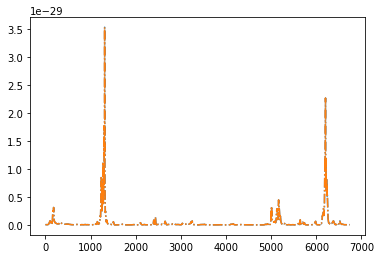

In [31]:
plt.plot(rho_tot*6.76991130339558456e-41,"-.")
plt.plot(hhh['rho_tot($i)'][...],'-.')

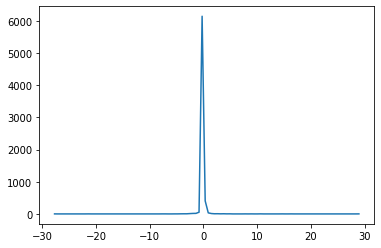

In [32]:
relativ_dif = (rho_tot*6.76991130339558456e-41-hhh['rho_tot($i)'][...])/np.average(hhh['rho_tot($i)'][...])
hist,bins = np.histogram(relativ_dif,bins=100)
bins_c = 0.5 * (bins[0:-1]+bins[1:])
plt.plot(bins_c,hist)

## Pythonize 

In [33]:
n_ion     =  np.zeros((nion,nveloc))
veloc_ion =  np.zeros((nion,nveloc))
temp_ion  =  np.zeros((nion,nveloc))
rho_ion   =  np.zeros((nion,nveloc))
rho_tot   =  np.zeros(nveloc)
temp_tot   =  np.zeros(nveloc)
met_tot   =  np.zeros(nveloc)
veloc_tot   =  np.zeros(nveloc)

In [38]:
t1 = time.time()
h2 = ParticleSmoothingLength**2
hinv2 = np.power(h2,-1)
hh      = ParticleSmoothingLength
hinv3 = hinv2 / ParticleSmoothingLength

dx = abs(Position_2[:,0] - x_physical)
dy = abs(Position_2[:,1] - y_physical)

zz = Position_2[:,2]
dx[dx > box_2] = box - dx[dx > box_2]
dy[dy > box_2] = box - dy[dy > box_2]

b2 = dx*dx + dy*dy
b = impactparameter = np.power(b2,0.5)

particle_mask = np.where(impactparameter <= hh)

if parameters.NoPecVel:
    vr = 0
else:
    vr = Velocity[i,los_long_axis]

Density = ParticleDensity[particle_mask] * densscale

log_dens = np.log10(Density)
log_temp = np.log10(ParticleTemperature[particle_mask])

ionfrac = [computeib(ib_redshift[iz1],ib_redshift[iz2],iz1, iz2, dz1, dz2, log_temp[i], log_dens[i], ib_logd, ionizbal, ib_logt, nz, nznt,parameters.use_fitted_ibfactor,parameters.ibfactor) for i in range(len(log_temp))]


iz = np.array((zz - zmingrid) * dzinv + 1).astype(int)

#contribute to projection segment

dzmax = np.sqrt(np.abs(h2 - b2))

ioff  = np.array(dzmax * dzinv).astype(int) + 1


iizg  = iz+ioff
iizi  = iz-ioff



totnr_ion = ionfrac*loss.MassFractions[:,ion_elnr[:]][particle_mask,:][0] * Mass[particle_mask][:, None] / ElementAtomicMass[:]

j = [list(range(iizi[i],iizg[i])) for i in range(len(iizi))]

for i,jj in enumerate(j):
    
    k = np.mod(np.array(jj)+10*nveloc,nveloc)
    
    zzgrid = zmingrid + (k - 0.5)*dzgrid
    deltaz = abs(zzgrid - zz[i])
    
    deltaz[deltaz > box_2] = box - deltaz[deltaz > box_2] 
    dr2 = b2[i] + deltaz**2
    zf = deltaz + dzgrid*0.5
    zi = deltaz - dzgrid*0.5
    q = np.sqrt(dr2 * hinv2[i])
    
    kernel_factor = np.zeros(np.shape(q))
    kernel_factor[q<0.5] = (1.+6*q[q<0.5]**2*(q[q<0.5]-1))
    kernel_factor[(0.5 < q) & (q < 1)] = 2.*(1-q[(0.5 < q) & (q < 1)])**3

    kernel_factor = (kernel_factor * 8. * hinv3[i]) / np.pi
    
    n_ion[:,k[kernel_factor>0]]      = n_ion[:,k[kernel_factor>0]]     + kernel_factor[kernel_factor>0] * totnr_ion[i,:,None]
    veloc_ion[:,k[kernel_factor>0]]  = veloc_ion[:,k[kernel_factor>0]] + kernel_factor[kernel_factor>0] * totnr_ion[i,:,None] * vr
    temp_ion[:,k[kernel_factor>0]]   = temp_ion[:,k[kernel_factor>0]]  + kernel_factor[kernel_factor>0] * totnr_ion[i,:,None] * loss.ParticleTemperature[i]
    rho_ion[:,k[kernel_factor>0]]    = rho_ion[:,k[kernel_factor>0]]   + kernel_factor[kernel_factor>0] * Density[i] * const.atomi_munit / loss.MassFractions[i,0]
    rho_tot[k[kernel_factor>0]]      = rho_tot[k[kernel_factor>0]]     + kernel_factor[kernel_factor>0] * Mass[i]
    veloc_tot[k[kernel_factor>0]]    = veloc_tot[k[kernel_factor>0]]   + kernel_factor[kernel_factor>0] * Mass[i] * vr
    temp_tot[k[kernel_factor>0]]     = temp_tot[k[kernel_factor>0]]    + kernel_factor[kernel_factor>0] * Mass[i] * loss.ParticleTemperature[i]
    met_tot[k[kernel_factor>0]]      = met_tot[k[kernel_factor>0]]     + kernel_factor[kernel_factor>0] * Mass[i] * loss.Metallicity[i]


t2 = time.time()
print("It took %f seconds" % (t2-t1))

It took 8.217322 seconds


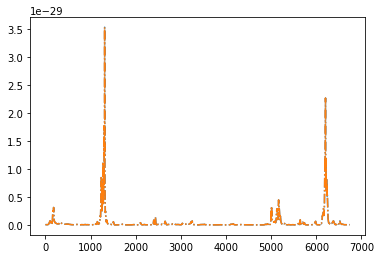

In [36]:
plt.plot(rho_tot*6.76991130339558456e-41,"-.")
plt.plot(hhh['rho_tot($i)'][...],'-.')

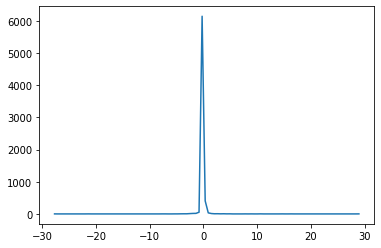

In [37]:
relativ_dif = (rho_tot*6.76991130339558456e-41-hhh['rho_tot($i)'][...])/np.average(hhh['rho_tot($i)'][...])
hist,bins = np.histogram(relativ_dif,bins=100)
bins_c = 0.5 * (bins[0:-1]+bins[1:])
plt.plot(bins_c,hist)

## Pythonized (scipy inter func) 

In [46]:
def Interp3D(indata, z,t,dens, value_array, verbose = 0, order=0 ):                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                     
    lo  = np.array([dens[0],t[0],z[0]])                                                                                                                                                                                                                                                                                
    hi  = np.array([dens[-1],t[-1],z[-1]])                                                                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                                                                                              
    theMaps = [ None, None,z[:]];                                                                                                                                                                                                                                                                                     
    interfunc = Intergrid( indata, lo=lo, hi=hi, maps= theMaps, prefilter=True, verbose = verbose,order=order );  
    return interfunc.at( value_array );

In [47]:
n_ion     =  np.zeros((nion,nveloc))
veloc_ion =  np.zeros((nion,nveloc))
temp_ion  =  np.zeros((nion,nveloc))
rho_ion   =  np.zeros((nion,nveloc))
rho_tot   =  np.zeros(nveloc)
temp_tot   =  np.zeros(nveloc)
met_tot   =  np.zeros(nveloc)
veloc_tot   =  np.zeros(nveloc)

In [48]:
ionss = []
first_iteration = True

for ion_file in ionbal_to_use:
    with h5.File(parameters.ibdir+ion_file+".hdf5","r") as f:
        if first_iteration:
            z_ranges_table = f["/redshift"][...]
            logt_table = f["/logt"][...]
            logd_table = f["/logd"][...]
            first_iteration = False

        ionss.append(f["/ionbal"][...])
        print(ion_file+' Ionization table loaded')

h1 Ionization table loaded
n2 Ionization table loaded
n5 Ionization table loaded
ne8 Ionization table loaded
si2 Ionization table loaded


In [49]:
t1 = time.time()
h2 = ParticleSmoothingLength**2
hinv2 = np.power(h2,-1)
hh      = ParticleSmoothingLength
hinv3 = hinv2 / ParticleSmoothingLength

dx = abs(Position_2[:,0] - x_physical)
dy = abs(Position_2[:,1] - y_physical)

dx[dx > box_2] = box - dx[dx > box_2]
dy[dy > box_2] = box - dy[dy > box_2]

zz = Position_2[:,2]


b2 = dx*dx + dy*dy
b = impactparameter = np.power(b2,0.5)

particle_mask = np.where(impactparameter <= hh)

if True:#parameters.NoPecVel:
    vr = 0
else:
    vr = Velocity[:,los_long_axis]


Density = ParticleDensity[particle_mask] * densscale

log_dens = np.log10(Density)
log_temp = np.log10(ParticleTemperature[particle_mask])
zarray = zcurrent*np.ones(len(log_temp))                                                                                                                                                                                                                                                                                            
iinput = np.array([log_dens,log_temp,zarray]).T


iz = np.array((zz - zmingrid) * dzinv + 1).astype(int)

#contribute to projection segment

dzmax = np.sqrt(np.abs(h2 - b2))

ioff  = np.array(dzmax * dzinv).astype(int) + 1


iizg  = iz+ioff
iizi  = iz-ioff
#ionfrac = [computeib(ib_redshift[iz1],ib_redshift[iz2],iz1, iz2, dz1, dz2, log_temp[i], log_dens[i], ib_logd, ionizbal, ib_logt, nz, nznt) for i in range(len(log_temp))]

des = [Interp3D(ionss[ll],z_ranges_table,logt_table,logd_table,iinput,verbose=0, order=1) for ll in range(len(ionss))]
ionfrac = np.transpose(des)
totnr_ion = ionfrac*loss.MassFractions[:,ion_elnr[:]][particle_mask,:][0] * Mass[particle_mask][:, None] / ElementAtomicMass[:]

j = [list(range(iizi[i],iizg[i])) for i in range(len(iizi))]

for i,jj in enumerate(j):
    chunks = np.mod(np.array(jj)+10*nveloc,nveloc)
    zzgrid = zmingrid + (chunks - 0.5)*dzgrid
    deltaz = abs(zzgrid - zz[i])
    
    deltaz[deltaz > box_2] = box - deltaz[deltaz > box_2] 
    
    dr2 = b2[i] + deltaz**2
    zf = deltaz + dzgrid*0.5
    zi = deltaz - dzgrid*0.5
    q = np.sqrt(dr2 * hinv2[i])
    
    kernel_factor = np.zeros(np.shape(q))
    q0p5 = q<0.5
    q1   = q<1
    kernel_factor[q0p5] = (1.+6*q[q0p5]**2*(q[q0p5]-1))
    kernel_factor[(q0p5) & (q1)] = 2.*(1-q[(q0p5) & (q1)])**3

    kernel_factor = (kernel_factor * 8. * hinv3[i]) / np.pi
    krnl_cond = kernel_factor>0
    
    n_ion[:,chunks[krnl_cond]]      = n_ion[:,chunks[krnl_cond]]     + kernel_factor[krnl_cond] * totnr_ion[i,:,None]
    veloc_ion[:,chunks[krnl_cond]]  = veloc_ion[:,chunks[krnl_cond]] + kernel_factor[krnl_cond] * totnr_ion[i,:,None] * vr
    temp_ion[:,chunks[krnl_cond]]   = temp_ion[:,chunks[krnl_cond]]  + kernel_factor[krnl_cond] * totnr_ion[i,:,None] * loss.ParticleTemperature[i]
    rho_ion[:,chunks[krnl_cond]]    = rho_ion[:,chunks[krnl_cond]]   + kernel_factor[krnl_cond] * Density[i] * const.atomi_munit / loss.MassFractions[i,0]
    rho_tot[chunks[krnl_cond]]      = rho_tot[chunks[krnl_cond]]     + kernel_factor[krnl_cond] * Mass[i]
    veloc_tot[chunks[krnl_cond]]    = veloc_tot[chunks[krnl_cond]]   + kernel_factor[krnl_cond] * Mass[i] * vr
    temp_tot[chunks[krnl_cond]]     = temp_tot[chunks[krnl_cond]]    + kernel_factor[krnl_cond] * Mass[i] * loss.ParticleTemperature[i]
    met_tot[chunks[krnl_cond]]      = met_tot[chunks[krnl_cond]]     + kernel_factor[krnl_cond] * Mass[i] * loss.Metallicity[i]




t2 = time.time()
print("It took %f seconds" % (t2-t1))

It took 6.962248 seconds


In [50]:
loss.rho_tot = rho_tot*6.76991130339558456e-41

In [51]:
loss.n_ion = n_ion
loss.veloc_ion = veloc_ion 
loss.temp_ion = temp_ion
loss.rho_ion  = rho_ion
loss.veloc_tot = veloc_tot
loss.temp_tot = temp_tot
loss.met_tot = met_tot

In [52]:
hhh = h5.File("../rhotot_los_1.hdf5", 'r')

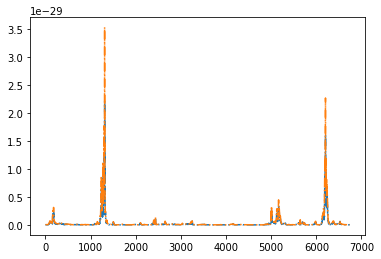

In [53]:
plt.plot(loss.rho_tot,"-.")
plt.plot(hhh['rho_tot($i)'][...],'-.')

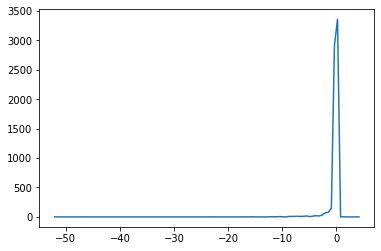

In [54]:
relativ_dif = (loss.rho_tot-hhh['rho_tot($i)'][...])/np.average(hhh['rho_tot($i)'][...])
hist,bins = np.histogram(relativ_dif,bins=100)
bins_c = 0.5 * (bins[0:-1]+bins[1:])
plt.plot(bins_c,hist)

In [35]:
parameters.NoPecVel

False

In [50]:
j[0]

[152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]